## Package import statements only

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date

from   scipy.optimize import curve_fit
from   sklearn.linear_model import LinearRegression

# import plotly as px

# Instructions from https://www.python-graph-gallery.com/choropleth-map-geopandas-python

# Import the geopandas and geoplot libraries
import geopandas as gpd
import geoplot as gplt
from bokeh.models import LinearColorMapper
from bokeh.palettes import brewer
import mapclassify as mc

%matplotlib inline

In [ ]:
# Load the json file with county coordinates
geoData = gpd.read_file('US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

# Remove Alaska, Hawaii and Puerto Rico.
stateToRemove = ['02', '15', '72']
geoData = geoData[~geoData.STATE.isin(stateToRemove)]
geoData.rename(columns={'id':'fips_code'}, inplace=True)

In [586]:
og_time_srs_df = pd.read_csv('/Users/josephgreene/Library/CloudStorage/Box-Box/project_county_covid_data')
og_static_df = pd.read_csv('/Users/josephgreene/GitHub/INFO2950Project/project_county_static_data')

In [594]:
time_srs_df = og_time_srs_df.copy()
static_df = og_static_df.copy()

## Functions

In [589]:
def static_as_of(date):
    '''
    @param date: str ex. 2021-11-17
    '''
    # creates df with static data merged on county data as of 'date'
    
    df = time_srs_df.loc[time_srs_df.date == pd.to_datetime(date)].copy()
    df.drop(columns=['cases','deaths'])
    
    merged_df = pd.merge(df,static_df,left_on='fips_code', right_on='FIPS_Code',how='inner')
    merged_df.drop(columns=['Unnamed: 0'], inplace=True)
    
    return merged_df

def remove_outliers(df, col, l_ptile, u_ptile):
    q1 = df[col].quantile(l_ptile)
    q3 = df[col].quantile(u_ptile)
    iqr = q3-q1

    upper = q3 + iqr
    lower = q1 - iqr
    
    return df.loc[((lower < df[col]) & (df[col] < upper))]

# permute func. from Lec. 14

def permute(input_array):
    # shuffle is inplace, so copy to preserve input
    permuted = input_array.copy().values #convert to numpy array, avoiding warning
    np.random.shuffle(permuted)
    return pd.Series(permuted) # convert back to pandas

# def create_reg_scatter(x,
# #                        x_rt,
#                        x_label,
# #                        x_rt_label,
#                        data=current_county_df,
#                        y='death_rate',
#                        y_rt='dr_rating',
#                        y_label='Death Rate (Cumulative Cases/Deaths)'):
#     data_for_regression = data.dropna(subset=[x,y])
    
#     current_linear_regression = LinearRegression()
#     current_linear_regression.fit(data_for_regression[[x]], data_for_regression[y])
#     y_pred = current_linear_regression.predict(data_for_regression[[x]])
    
#     plt.figure(figsize=(12,10));

#     fig, ax = plt.subplots();

#     ax = sns.scatterplot(
#         x=x,
#         y=y,
#         data=data_for_regression,
#         alpha=.5,
# #         hue=x_rt,
#     #     style='dr_rating',

#     );

#     ax2 = sns.lineplot(
#         x=x,
#         y=y_pred,
#         color='darkorange',
#         data=data_for_regression,
#     );

#     date = str(data.loc[0]['date'].date())

#     plt.title(f'{y_label} vs. {x_label} as of {date}'.title())
#     plt.xlabel(x_label)
#     plt.ylabel(y_label)
# #     plt.legend([x_rt_label])
#     plt.show();
    
def plot_model_line(df,x,y, model, is_resampled=True):
    '''
    Takes a dataframe and a fitted model
    Plots a line of best fit to the data
    '''
    if is_resampled:
        color="grey"
        alpha=0.1
    else:
        color="steelblue"
        alpha=0.7
    plt.plot(df[x], df[x] * model.coef_[0] + model.intercept_, color=color, alpha=alpha)

In [729]:
class Variable:
    def __init__(self, x, x_rt, x_label, date='2021-11-17', y='death_rate', y_rt='dr_rating', y_label='Death Rate (Cumulative Cases/Deaths)'):
        self.x = x
        self.x_rt = x_rt
        self.x_label = x_label
        self.x_rt_label = x_label + ' Rating'
        self.y = y
        self.y_rt = y_rt
        self.y_label= y_label
        self.date = date
        self.data = static_as_of(date).replace(np.inf,np.nan).dropna(subset=[self.x, self.y])
        self.model = LinearRegression().fit(self.data[[self.x]], self.data[self.y])
        self.model_score = self.model.score(self.data[[x]], self.data[self.y])
        
        
    def reg_scatter(self):
        create_reg_scatter(self.x, self.x_label)
        
    def perm_reg_scatter(self):
        
        # from lecture:

        plt.figure(figsize=(10,10))

        # plot true data
        plt.scatter(x=self.data[self.x], y=self.data[self.y], alpha=.3)

        # plot 100 iterations of models on permuted data
        for i in range(100):
            permuted_model = LinearRegression().fit(self.data[[self.x]], permute(self.data[self.y]))
            plot_model_line(self.data, self.x, self.y, permuted_model)

        # model true data and plot
        plot_model_line(self.data, self.x, self.y, self.model, is_resampled=False)

        plt.xlabel(self.x_label)
        plt.ylabel(self.y_label)

        plt.show()        
        
        
    def reg_scatter(self):
        
        # creates a linear regression line of best fit and plots it along with the data (data as scatterplot)

        y_pred = self.model.predict(self.data[[self.x]])

        plt.figure(figsize=(10,10));

        fig, ax = plt.subplots();

        ax = sns.scatterplot(
            x=self.x,
            y=self.y,
            data=self.data,
            alpha=.5,
    #         hue=x_rt,
        #     style='dr_rating',

        );

        ax2 = sns.lineplot(
            x=self.x,
            y=y_pred,
            color='darkorange',
            data=self.data,
        );

        date = str(self.data.loc[0]['date'].date())

        plt.title(f'{self.y_label} vs. {self.x_label} as of {date}'.title())
        plt.xlabel(self.x_label)
        plt.ylabel(self.y_label)
        plt.legend([self.x_rt_label])
        plt.show();
    
    def perm_test_hist(self):

        # Code from lecture

        # what fraction of permuted (null hyopthesis) slopes are greater than our observed slope?

        steeper_slopes = 0
        n_permutations = 1000
        permuted_slopes = np.zeros(n_permutations) # preallocate array of correct size

        for i in range(n_permutations):
            permuted_model = LinearRegression().fit(self.data[[self.x]], permute(self.data[self.y]))

            permuted_slopes[i] = permuted_model.coef_[0]

            if np.abs(permuted_model.coef_[0]) > np.abs(self.model.coef_):
                steeper_slopes += 1

        df_permuted_slopes = pd.DataFrame({'permuted_slopes': np.array(permuted_slopes)})

        binsizes, _, _ = plt.hist(permuted_slopes, bins=50)
        plt.vlines(self.model.coef_[0], ymin=0, ymax=np.max(binsizes), color='red')
        plt.vlines(df_permuted_slopes.quantile(.95),  ymin=0, ymax=np.max(binsizes), color='green')
        plt.vlines(df_permuted_slopes.quantile(.05),  ymin=0, ymax=np.max(binsizes), color='green')

        plt.show();
        
    def boxplot(self):
        boxplot = sns.boxplot(
            x=self.x_rt,
            y=self.y,
            data=self.data
        )
        
        boxplot.figure.set_size_inches(4,6)
        
        plt.xlabel(self.x_rt_label)
        plt.ylabel(self.y_label)
        plt.show();
    
    def displot(self):
        plot = sns.displot(
            self.data,
            x = self.y,
            hue = self.x_rt,
            kind = 'kde',
            fill = True

        )
        
        plt.xlabel(self.x_label)
        plt.ylabel(self.y_label)
        plot.figure.set_size_inches(13,5)
        
    def choropleth(self):
        county_geo_covid_current = pd.merge(geoData,
                                            self.data.loc[:,['fips_code',self.x_rt,self.x]], 
                                            how='left', on='fips_code')

        county_geo_covid_current.dropna(subset=[self.x], inplace=True)

        palette = brewer['YlGnBu'][8]

        color_mapper = LinearColorMapper(palette = palette, low = 0, high = 40, nan_color = '#d9d9d9')




        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.axis('off')

        # Set up the color sheme:
        scheme = mc.Quantiles(county_geo_covid_current[self.x], k=6)

        # Map
        gplt.choropleth(county_geo_covid_current, 
            hue=self.x, 
            linewidth=.1,
            scheme=scheme,
            cmap='Reds',
            legend=True,
            edgecolor='black',
            ax=ax,

        );

        ax.set_title(self.x_label, fontsize=24);
        



## Recleaning

In [595]:
static_df['income_rating'] = pd.to_numeric(pd.qcut(static_df.med_income, 6, labels=list(range(6))))

In [599]:
# Cleaning the time series data

time_srs_df['date'] = pd.to_datetime(time_srs_df['date'])
# time_srs_df.drop(columns='Unnamed: 0',inplace=True)
time_srs_df['death_rate'] = time_srs_df['tot_deaths'] / time_srs_df['tot_cases']
time_srs_df['dr_rating'] = pd.to_numeric(pd.qcut(time_srs_df.death_rate, 6, labels=list(range(6))))
time_srs_df['rec_death_rate'] = time_srs_df.deaths.rolling(30).sum() / time_srs_df.cases.rolling(7).sum()
time_srs_df['rec_dr_rating'] = pd.to_numeric(pd.qcut(time_srs_df['rec_death_rate'], 6, labels=list(range(6)), duplicates='drop'))

In [750]:
# creating df with most current data

max_date = str(time_srs_df.date.max()).split()[0]
current_county_df = static_as_of(max_date)

In [751]:
int_speed = Variable('AverageMbps','avg_mbps_rating', 'Average Mb/s')
income = Variable('med_income', 'income_rating','Median Household Income (2019)')
# rec_travel = Variable('rec_stay_rate','rec_stay_rating','7-Day Rolling Average of % of Population Leaving Home', y='rec_death_rate',y_rt='rec_dr_rating',y_label='7-Day Rolling Average Death Rate (Deaths/Cases)')

# Introduction

This report discusses the relationships between two US county-level variables, income and internet speed, and county level Covid-19 response. We examine whether there is a significant relationship between a county's death rate (# deaths / # cases) and the two variables. Covid response is represented with death rate because this calculation gives a reference for the amount of cases that a county failed to handle, as in, the amount of cases that ended in the individual dying. We will show there is a significant relationship between covid response and both income and internet speed. Meaning, the better a county's internet, or the more affluent a county is, the better they were able to handle Covid cases.

---

## Cases and deaths over the last year


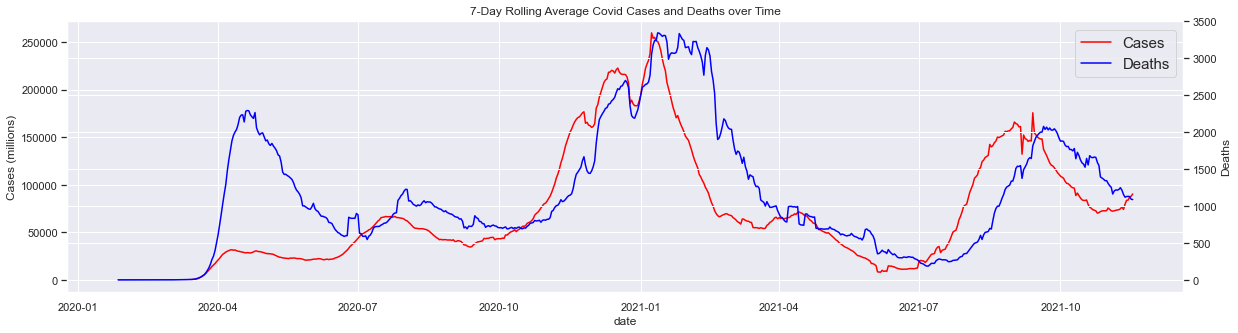

In [780]:
temp_df = time_srs_df.groupby(by=pd.to_datetime(time_srs_df.date)).sum()
fig, ax = plt.subplots()


sns.set_theme()

ax = sns.lineplot(
    x=temp_df.index,
    y=temp_df.cases.rolling(7).mean(),
    data=temp_df,
    color='red',
)

ax2 = ax.twinx()
ax2 = sns.lineplot(
    x=temp_df.index,
    y=temp_df.deaths.rolling(7).mean(),
    data=temp_df,
    color='blue'
)

sns.set(rc = {'figure.figsize':(20,5)})

fig.legend(['Cases','Deaths'],loc='upper right', bbox_to_anchor=(.90, .875),prop={'size': 15})

# ax.vlines(pd.to_datetime('2021-01-08'),  ymin=0, ymax=np.max(temp_df.cases.rolling(7).mean()), color='green')
# ax.vlines(pd.to_datetime('2021-09-13'),  ymin=0, ymax=np.max(temp_df.cases.rolling(7).mean()), color='green')

plt.title('7-Day Rolling Average Covid Cases and Deaths over Time')
ax2.set_ylabel('Deaths')
ax.set_ylabel('Cases (millions)')
plt.xlabel('Date')

plt.show()

The plot above shows how cases and deaths have tracked along the pandemic. As one can see, during the first wave, when medical professionals were most unprepared (relative to the rest of the pandemic), more deaths occured for each case.

# Data description.
The data for this report is split between two datasets, with static and time-series.


## Time-Series data
This dataset includes data from January, 2020, to November, 2021. Each observation represents a county on a day. For each day, each county observation includes:

`date` - date of observation

`county` - county name

`state` - state name

`cases` - new cases

`deaths` - new deaths

`tot_cases` - cumulative cases

`tot_deaths` - cumulative deaths

`death_rate` - our Covid response metric, calculated by cumulative deaths / cumulative cases

`fips_code` - Federal Information Processing Standard, a code representing each US county

`dr_rating` - categorical variable with six bins, derived from `death_rate`

`rec_stay_rate` - 7-Day rolling average % of population staying home

`rec_stay_rating` - categorical variable with six bins, derived from `rec_stay_rate`

`rec_death_rate` - 30-Day rolling average death rate

`rec_dr_rating` - categorical variable with six bins, derived from `rec_death_rate`

## Static Data
Each observation represents a FIPS code (a county). Each county has four attributes, two relate to internet speed, and two relate to income. This data is merged with the time series data of a single date. 

### Internet
`AverageMbps` - the 12-month average of internet speed test results recorded by Measurement Labs for a given county in 2020. 

`avg_mbps_rating` - a categorical variable, with six bins, made from the `AverageMbps` attribute.

### Income
`med_income` - the 2019 median household income for a county.

`income_rating` - a categorical variable, with six bins, made from the `med_income` data.


The data comes from several sources. The Covid data was taken from the [New York Times](https://github.com/nytimes/covid-19-data). The travel data comes from the [Bureau of Transportation Statistics](https://data.bts.gov/Research-and-Statistics/Trips-by-Distance/w96p-f2qv). The income data comes from the US department of Agriculture's [Economic Research Service](https://www.ers.usda.gov/data-products/county-level-data-sets/). Finally, the internet speed test data comes from [BroadbandNow](https://github.com/BroadbandNow/Open-Data), a company that provides internet service provider comparisons for consumers.

---

# Preregistered Analyses
During the preregistration, we committed to providing analysis on the following questions:
- What is the relationship between access to wifi and Covid transmission?
- Did vaccinations or transmission have a more significant relationship with travel?

We move from looking at vaccinations, travel to working with income data. While we could have spent more time looking at the the time-series vaccination and travel data, we felt the analysis would be more fruitful if our time was spent comparing the relationships of the static variables, median income and internet speed, to death rate.

---

# Data Analysis

## Looking at the data
Below are two choropleth visualizations displaying the wealth and internet distributions from the dataset.

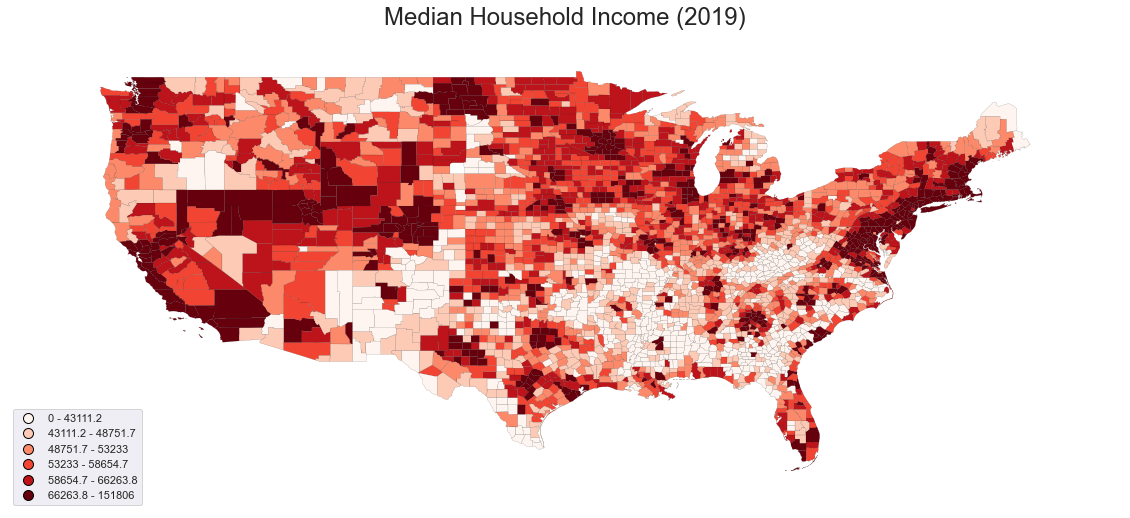

In [603]:
income.choropleth()

The map above shows the northeast and west coast are the most dense areas of high median income. Unsuprisingly, the map below shows a somewhat similar distribution for internet speed.

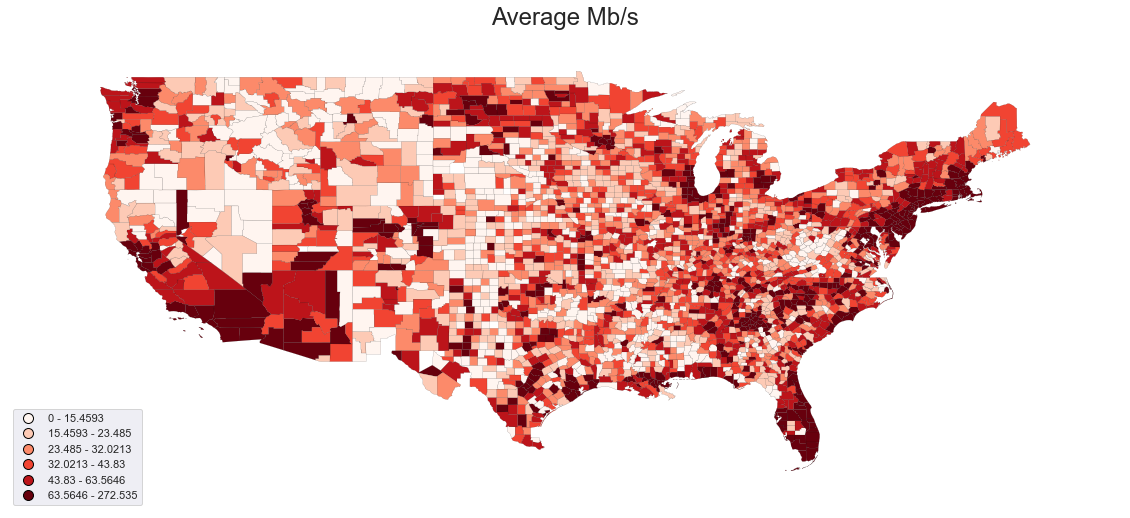

In [604]:
int_speed.choropleth()

Compare the choropleth maps above to the map showing county death rates below. Though the two above show slightly similar distributions, the Covid death rate map below shows the most dense region of high death rates is in the south.

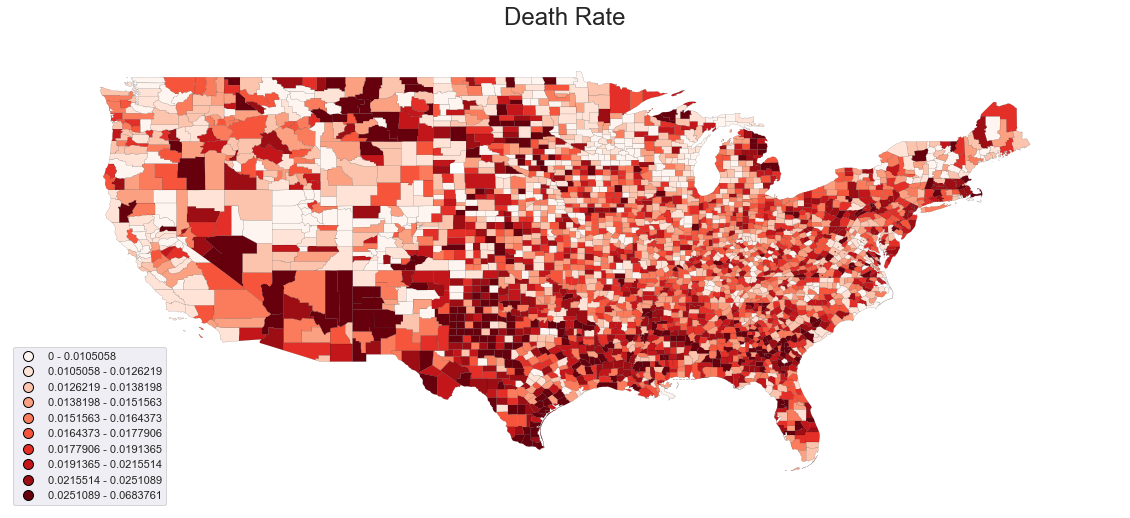

In [777]:
# https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0
# link above to instructions on filling na values and displaying as greyed out

county_geo_covid_current = pd.merge(geoData, current_county_df, how='left', on='fips_code')


county_geo_covid_current.dropna(subset=['death_rate'], inplace=True)

palette = brewer['YlGnBu'][8]

color_mapper = LinearColorMapper(palette = palette, low = 0, high = 40, nan_color = '#d9d9d9')




fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.axis('off')

# Set up the color sheme:
scheme = mc.Quantiles(county_geo_covid_current['death_rate'], k=10)

# Map
gplt.choropleth(county_geo_covid_current, 
    hue="death_rate", 
    linewidth=.1,
    scheme=scheme,
    cmap='Reds',
    legend=True,
    edgecolor='black',
    ax=ax,
    
);

ax.set_title('Death Rate', fontsize=24);



---

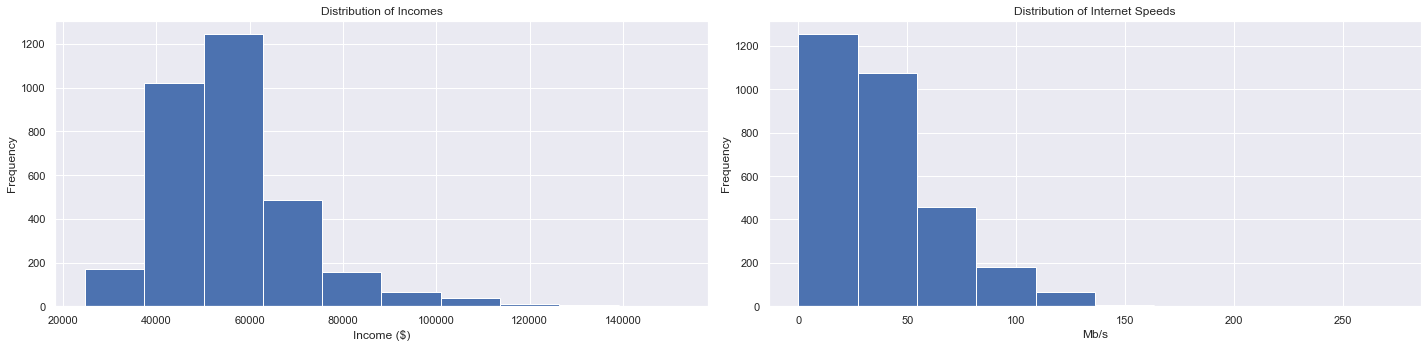

In [605]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.hist(x=static_df.med_income);
ax1.set_xlabel('Income ($)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Incomes')

ax2.hist(x=static_df.AverageMbps);
ax2.set_xlabel('Mb/s')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Internet Speeds')

plt.tight_layout();
plt.show();

Income shows a somewhat normal distribution, with a slight rightward skew. The internet speed data heavily skewed rightward.

In [781]:
static_df.loc[:,['med_income','AverageMbps']].describe()

,med_income,AverageMbps
count,3193.000000,3049.000000
mean,55874.761979,39.550000
std,14493.345229,27.780166
min,24732.000000,0.000000
25%,46309.000000,19.503636
50%,53505.000000,32.113333
75%,62327.000000,52.782000
max,151806.000000,272.535000


The average median income for US counties in 2019 was $55,874. The average internet speed for US counties in 2020 was 39.55 Mb/s.

---

## Looking at the most recent data (2021-11-17)

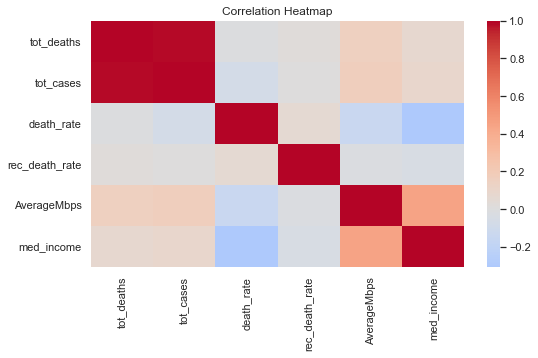

In [785]:
plt.figure(figsize=(8,5))
sns.heatmap(current_county_df.loc[:,['tot_deaths', 'tot_cases','death_rate','rec_death_rate','AverageMbps','med_income']].corr(),center=0,cmap='coolwarm')
plt.tight_layout()
plt.title(f'Correlation Heatmap')
plt.show()

There seems to be a slight negative relationship between both our variables and death rate. There also seems to be a positive relationship between our predictor variables, income and internet speed.

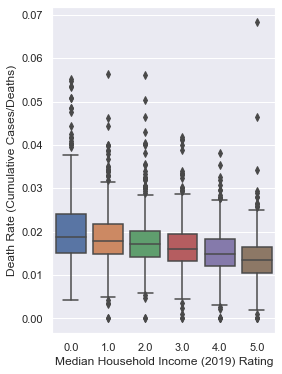

In [782]:
income.boxplot()

The boxplot above shows the distribution of death rates for each of six income brackets. As the plot shows, higher income brackets experienced lower death rates. This can also be seen in the following distribution plot.

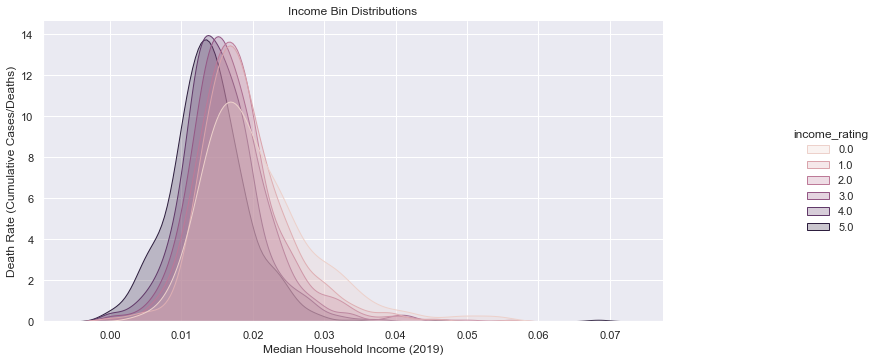

In [755]:
income.displot()
plt.title('Income Bin Distributions')
plt.show()

---
The following box and distribution plots show the distribution of death rates at different internet speed brackets. Compared to income, death rate distribution seems to be similar among the different speed brackets.

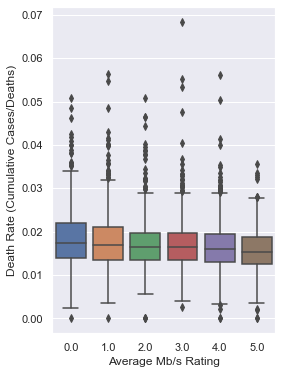

In [779]:
int_speed.boxplot()

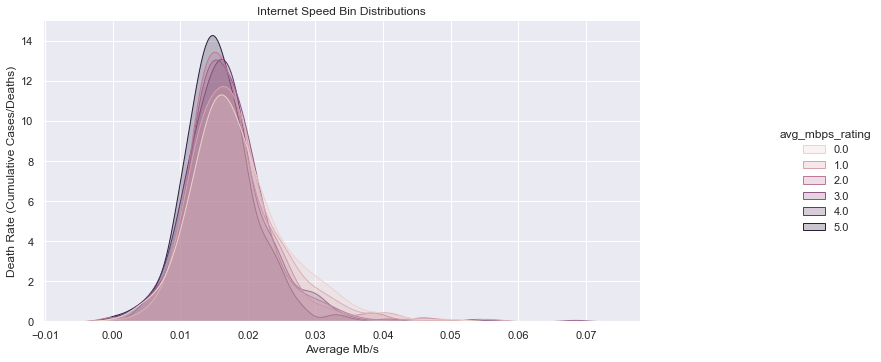

In [756]:
int_speed.displot()
plt.title('Internet Speed Bin Distributions')
plt.show()

From the boxplots and distributions, it would seem income has a more significant relationship with death rate than internet speed.

## Modeling

<Figure size 720x720 with 0 Axes>

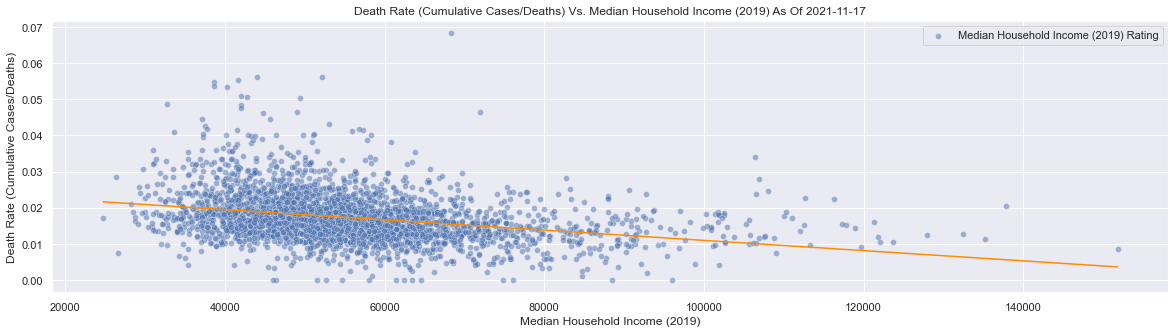

Coefficient: -0.00000014
r^2 score: 0.094


In [762]:
income.reg_scatter();
print(f'Coefficient: {income.model.coef_[0]:.8f}')
print(f'r^2 score: {income.model_score:.3f}')

<Figure size 720x720 with 0 Axes>

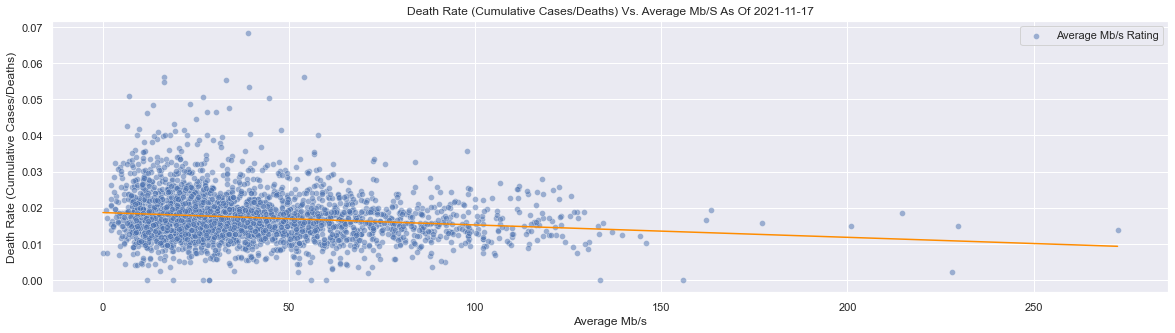

Coefficient: -0.000034
r^2 score: 0.021


In [760]:
int_speed.reg_scatter();
print(f'Coefficient: {int_speed.model.coef_[0]:.6f}')
print(f'r^2 score: {int_speed.model_score:.3f}')

The coefficients of the lines of best fit for each variable are extremely close to zero. While this means the income and internet speed have very little effect on death rate, it does not mean the relationship is insignificant. The hypothesis testing below shows the relationships are significant.

# Evaluation of significance

For the significance testing, we ran 1000 permutation tests on each relationship. First, we will look at the relationship between internet speed and death rate.

---

## Internet Speed and Death Rate

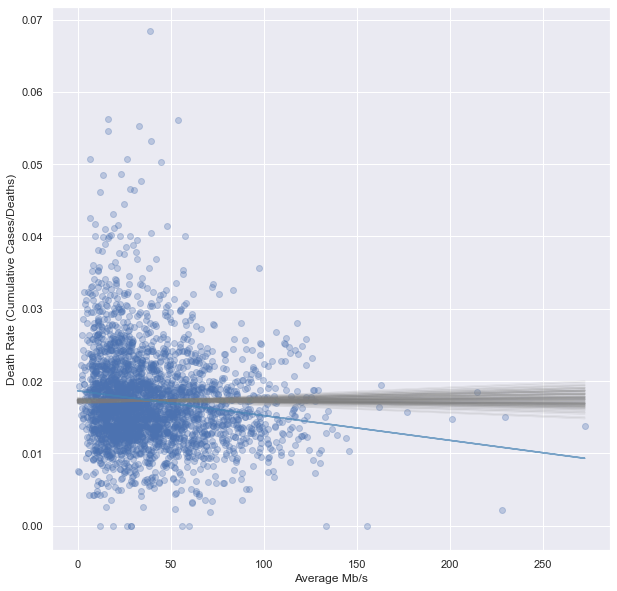

In [766]:
int_speed.perm_reg_scatter()

Our model's line of best fit (blue) is more significant than the slopes of the randomized data (grey), leading us to believe a significant relationship exists. This can be seen further in the following histogram, which shows where our relationship falls relative to the permuted ones. The green lines represent the 95% intervals, within which we would have deemed the relationship insignificant.

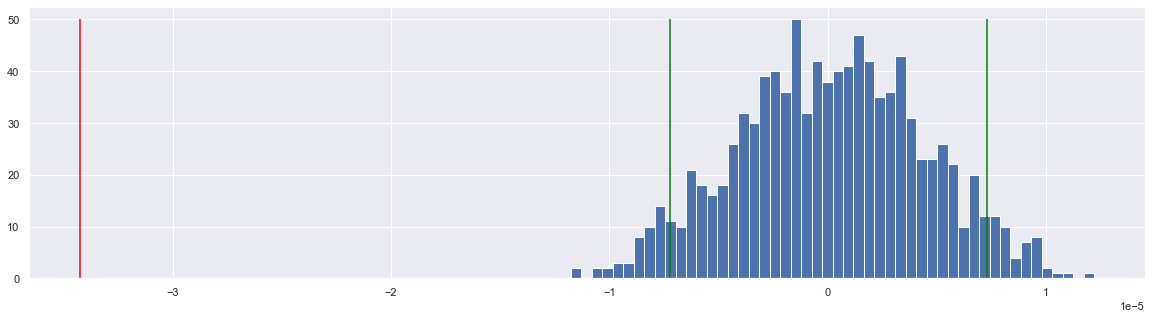

In [768]:
int_speed.perm_test_hist()

As shown above, the relationship falls far outside the 95% confidence interval, again, leading us to conclude it is significant.

---
## Income and Death Rate
Now, we will examine the relationship between median household income and death rate.

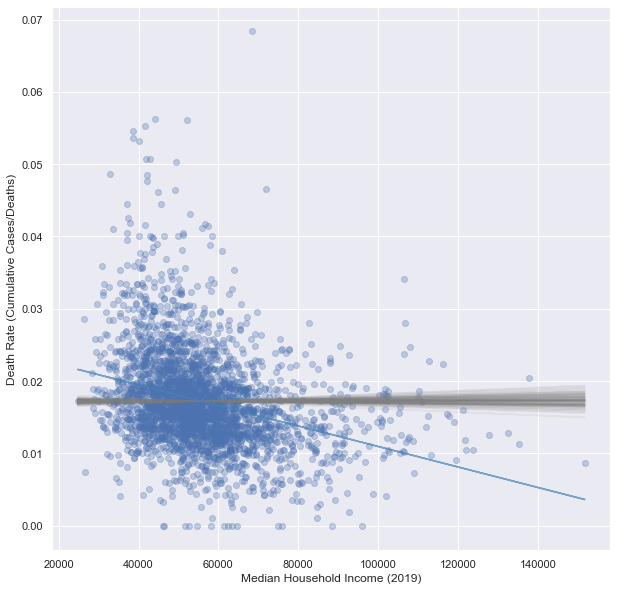

In [771]:
income.perm_reg_scatter()

Here, again, the relationship of the model fitted on our true data (blue) seems to fall far outside the range of randomly fitted slopes. We will again examine a histogram to see how far our relationship falls from the rest of the data.

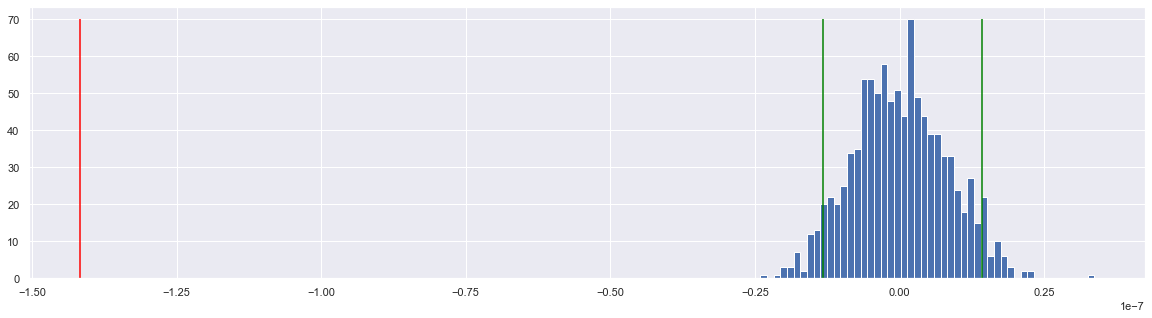

In [773]:
income.perm_test_hist()

As the plot above shows, the relationship falls outside the 95% confidence interval, allowing us to confidently reject the null hypothesis. From these tests, it would seem the relationship between income and death rate is more significant than that between internet speed and death rate.

# Conclusion

The analysis above shows the relationships are significant, but have very shallow slopes, rendering the model unuseful for predicting significant effects of average internet speed and median income on Covid response.

Our models predict:
  
    1. For every Mb/s increase in a county's average internet speed, that county's death rate decreases by 0.000034.
    
    2. For every $ increase in median income, a county's death rate decreases by 0.00000014.

We are confident these relationships are significant, while recognizing the limited utility they yeild. However, we do believe the relationship between income and covid response have important implications, that is, state and the federal government should work to balance the distribution of resources according to which areas are more likely to be hit harder by the virus (i.e., less affluent areas).



# Limitations

We recognize our analysis has limitations. First, the Covid data is unlikely extremely accurate, areas with less access to resources likely could not afford to test as many individuals for covid, resulting in even fewer cases reported than actually happened relative to areas with the resources to test all those who believe they may have had Covid. We also recognize that many deaths that may not have been due to Covid were recorded as Covid-related deaths. Our hope is that this erroneous recording occured somewhat equally across counties. We also make note of the accuracy of the internet speed tests. Internet speeds were recorded when individuals ran speed tests. Most individuals only run internet speed tests when their internet connection is not operating as the individual believes it should, therefore, the results may depict slightly polarized speeds compared to the true averages. Nonetheless, we feel these potential limitations do not negate the results.

# Source Code:

Code:
- County-level data cleaning
- Original, state-level data cleaning, containing 4 APIs, that were cleaned and used for the original version of this project

Data:
- Cleaned project data
    - [Time-series data](https://cornell.box.com/s/r2nt7zn99obd01ntii6pzdxoh98xey1p)
    - [Static data](
    
- Raw data
    - 
